In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import awkward as ak
from fast_histogram import histogram2d
import seaborn as sn
from sklearn.preprocessing import normalize
import h5py

# Converting calorimeter input to 2D histogram images

This script creates calorimeter images based on the calorimeter data from the ATLAS Open jet reconstruction data. 

In [2]:
MIN_RES = 20
RESOLUTION = int(5*MIN_RES)
N_events = 10000 #events to load
MAX_EVENTS = 10000 #images to make
savepath = "/disk/atlas3/data_MC/2dhistograms"
filename = "ttbar"

#data_paths = ['/disk/atlas3/data_MC/delphes/black_holes_10000events.root:Delphes']
data_paths = ["/disk/atlas3/data_MC/delphes/ttbar_13TeV_pTmin1000_10000events.root:Delphes"]
#data_paths = ["/disk/atlas3/data_MC/delphes/sphalerons.root:Delphes"]

#filters = ["saturate"]
filters = ["none"]

In [3]:
def cal_image_plot(ax):
    """
    Formating of calorimeter image
    """
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    #ax.set_title("Calorimeter image", fontsize=20, color="black")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

def create_histograms(x, y, z):
    max_available_events = len(x)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    Cal = [histogram2d(x[i], y[i], 
            range=[[-np.pi, np.pi], [-2.5, 2.5]], bins=RESOLUTION, 
            weights=z[i]) 
            for i in range(0, max_events)]
    return Cal

def preproc_histograms(hists:list):
    hists = [item/np.amax(item) for item in hists]
    return hists

def apply_filters(key_list, image):
    for key in key_list:
        if key=="saturate":
            image[np.nonzero(image)] = 255
            image = image.astype(int)
            print(f"Applying {key} filter.")
    return image

Using the with uproot loop, we can extract only the data we need and then close the original file. This will save us memory space.

In [4]:
#Open file in with-function will close it when you exit
def load_data(rootfile:str, branch:str, keys:list):
    with uproot.open(rootfile) as file:
        valid_list = [key in file.keys() for key in keys]
        if valid_list:
            arr = file[branch].arrays(keys, library="ak", how="zip")[0:N_events]
            return arr[branch]
        else:
            print(keys[not(valid_list)], " not present in data.")


clusters = [load_data(path, "Tower", 
                        ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Tower.E"])
                        for path in data_paths]
tracks = [load_data(path, "Track", 
                        ["Track.PT", "Track.Eta", "Track.Phi"])
                        for path in data_paths]

print("Number of events: ", [len(item) for item in clusters])

Number of events:  [10000]


In [5]:
#Pad Tower data and normalise
max_hits = np.max([np.max([len(event) for event in item["Eta"]]) for item in clusters])
print(max_hits)
clusters = [ak.pad_none(item, max_hits, axis=-1) for item in clusters]

#normalise and remove None
for i in range(len(clusters)):
    ak.fill_none(clusters[i], 0)
    clusters[i].Eem_norm = clusters[i].Eem/ak.max(clusters[i].Eem, axis=1)
    clusters[i].Ehad_norm = clusters[i].Ehad/ak.max(clusters[i].Ehad, axis=1)
    clusters[i].ET_norm = clusters[i].ET/ak.max(clusters[i].ET, axis=1)

#Pad track data and normalise
max_hits = np.max([np.max([len(event) for event in item["Eta"]]) for item in tracks])
print(max_hits)
tracks = [ak.pad_none(item, max_hits, axis=-1) for item in tracks]

#normalise
for i in range(len(tracks)):
    ak.fill_none(tracks[i], 0)
    tracks[i].PT_norm = tracks[i].PT/ak.max(tracks[i].PT, axis=1)

450
242


We create the histograms by using the [fast-histogram library](https://pypi.org/project/fast-histogram/), which is 20-25 x faster than numpy.histogram2d. It does not support advanced binning however, so we perform a simple binning equal to the desired resolution of the image. 

In [6]:
hists_Eem = create_histograms(ak.to_numpy(clusters[0].Phi), ak.to_numpy(clusters[0].Eta), ak.to_numpy(clusters[0].Eem_norm))
hists_Ehad = create_histograms(ak.to_numpy(clusters[0].Phi), ak.to_numpy(clusters[0].Eta), ak.to_numpy(clusters[0].Ehad_norm))
hists_tracks = create_histograms(ak.to_numpy(tracks[0].Phi), ak.to_numpy(tracks[0].Eta), ak.to_numpy(tracks[0].PT))
#normalise
hists_Eem = preproc_histograms(hists_Eem)
hists_Ehad = preproc_histograms(hists_Ehad)
hists_tracks = preproc_histograms(hists_tracks)

Remember that python histograms produce images with input 2 (eta) on the x-axis and input 1 (phi) on the y-axis.

(10000, 100, 100, 3)


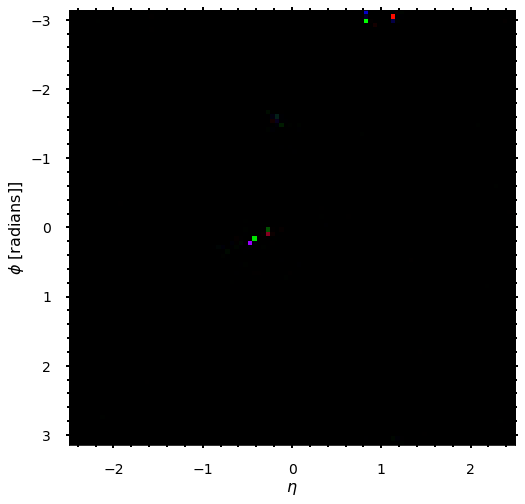

In [7]:
k = np.random.randint(0, high=len(hists_Eem)) #a random image
images = np.stack((hists_Eem, hists_Ehad, hists_tracks), axis=-1)
images = apply_filters(filters, images)
print(images.shape)
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
cal_image_plot(axs)
image = images[k]
image = apply_filters(filters, image)
axs.imshow(image, extent=[-2.5, 2.5, np.pi, -np.pi], aspect='auto')

In [8]:
def store_many_hdf5(images, savepath, filename, filters, labels=None):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (MAX_EVENTS, RESOLUTION, RESOLUTION, 3) to be stored
        labels       labels array, (MAX_EVENTS, 1) to be stored
    """
    num_images = len(images)
    
    def make_filter_code(filters):
        if filters[0] != "":
            letter_list = [x[0]+"_" for x in filters]
            code = ""
            code = code.join(letter_list)
            code = code[:-1]
        return str(code)
    filter_code = make_filter_code(filters)
    print(f"{savepath}/{filename}_{MAX_EVENTS}_events_{filter_code}.h5")

    # Create meta data
    meta = {
        "RESOLUTION": RESOLUTION,
        "Filters" : filters,
        "Events" : MAX_EVENTS,
        "Input" : data_paths[0]
    }

    # Create a new HDF5 file
    file = h5py.File(f"{savepath}/{filename}_{MAX_EVENTS}_events_{filter_code}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    for key, value in meta.items():
        meta_set = file.create_dataset(
            key, np.shape(value), data=value
        )
    file.close()

store_many_hdf5(images, savepath, filename, filters)

/disk/atlas3/data_MC/2dhistograms/ttbar_10000_events_n.h5
